<a href="https://colab.research.google.com/github/sparab2/ML_Project_Traffic/blob/main/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load the CSV file from your Google Drive
df = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/US_Accidents_Dec21_updated.csv')

df.head() # To get first n rows from the dataset default value of n is 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [3]:
df.drop(['ID', 'Wind_Speed(mph)', 'Wind_Direction', 'Country', 'City', 'State', 'County', 'Zipcode', 'Street', 'Side', 'Number', 'Airport_Code', 'Description', 'Visibility(mi)',	'End_Lat',	'End_Lng', 'Timezone', 'Weather_Timestamp', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1, inplace=True)
# Step 6: Remove duplicates
df.drop_duplicates(inplace=True)
print(df.columns)

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset'],
      dtype='object')


In [4]:
# Step 1: Rename columns
df.rename(columns={'Start_Time': 'start_time', 'End_Time': 'end_time', 'Severity': 'severity', 'Distance(mi)': 'distance'}, inplace=True)
print(df.columns)

Index(['severity', 'start_time', 'end_time', 'Start_Lat', 'Start_Lng',
       'distance', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset'],
      dtype='object')


In [5]:
# Step 7: Encode categorical variables
df['Weather_Condition'] = pd.factorize(df['Weather_Condition'])[0]

print(df.head())

   severity           start_time             end_time  Start_Lat  Start_Lng  \
0         3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108910 -83.092860   
1         2  2016-02-08 05:56:20  2016-02-08 11:56:20  39.865420 -84.062800   
2         2  2016-02-08 06:15:39  2016-02-08 12:15:39  39.102660 -84.524680   
3         2  2016-02-08 06:51:45  2016-02-08 12:51:45  41.062130 -81.537840   
4         3  2016-02-08 07:53:43  2016-02-08 13:53:43  39.172393 -84.492792   

   distance  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  ...  \
0     3.230            42.1           36.1         58.0         29.76  ...   
1     0.747            36.9            NaN         91.0         29.68  ...   
2     0.055            36.0            NaN         97.0         29.70  ...   
3     0.123            39.0            NaN         55.0         29.65  ...   
4     0.500            37.0           29.8         93.0         29.69  ...   

   Junction  No_Exit  Railway  Roundabout  Station   Sto

In [6]:
# Replace missing values with mean
imputer = SimpleImputer(strategy='mean')
num_cols = ['distance', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Precipitation(in)']
df[num_cols] = imputer.fit_transform(df[num_cols])
print(df.head())

   severity           start_time             end_time  Start_Lat  Start_Lng  \
0         3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108910 -83.092860   
1         2  2016-02-08 05:56:20  2016-02-08 11:56:20  39.865420 -84.062800   
2         2  2016-02-08 06:15:39  2016-02-08 12:15:39  39.102660 -84.524680   
3         2  2016-02-08 06:51:45  2016-02-08 12:51:45  41.062130 -81.537840   
4         3  2016-02-08 07:53:43  2016-02-08 13:53:43  39.172393 -84.492792   

   distance  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  ...  \
0     3.230            42.1      36.100000         58.0         29.76  ...   
1     0.747            36.9      59.705765         91.0         29.68  ...   
2     0.055            36.0      59.705765         97.0         29.70  ...   
3     0.123            39.0      59.705765         55.0         29.65  ...   
4     0.500            37.0      29.800000         93.0         29.69  ...   

   Junction  No_Exit  Railway  Roundabout  Station   Sto

In [7]:
# Step 4: Convert data types
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

In [8]:
df['Amenity'] = df['Amenity'].astype(str)
df['Bump'] = df['Bump'].astype(str)
df['Crossing'] = df['Crossing'].astype(str)
df['Give_Way'] = df['Give_Way'].astype(str)
df['Junction'] = df['Junction'].astype(str)
df['No_Exit'] = df['No_Exit'].astype(str)
df['Railway'] = df['Railway'].astype(str)
df['Roundabout'] = df['Roundabout'].astype(str)
df['Station'] = df['Station'].astype(str)
df['Stop'] = df['Stop'].astype(str)
df['Traffic_Calming'] = df['Traffic_Calming'].astype(str)
df['Traffic_Signal'] = df['Traffic_Signal'].astype(str)
df['Turning_Loop'] = df['Turning_Loop'].astype(str)

df['Sunrise_Sunset'] = df['Sunrise_Sunset'].astype(str)

In [9]:
binary_vars = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
day_vars = ['Sunrise_Sunset']


# Convert the binary variables to 0/1
df[binary_vars] = df[binary_vars].apply(lambda x: x.map({"True": 1, "False": 0}))

# Convert the binary variables to 0/1
df[day_vars] = df[day_vars].apply(lambda x: x.map({"Day": 1, "Night": 0}))

In [10]:
df[binary_vars] = df[binary_vars].astype(str)
df[day_vars] = df[day_vars].astype(str)
df.head() 

,severity,start_time,end_time,Start_Lat,Start_Lng,distance,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,3.230,42.1,36.100000,58.0,29.76,...,0,0,0,0,0,0,0,0,0,0.0
1,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,0.747,36.9,59.705765,91.0,29.68,...,0,0,0,0,0,0,0,0,0,0.0
2,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,0.055,36.0,59.705765,97.0,29.70,...,1,0,0,0,0,0,0,0,0,0.0
3,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,0.123,39.0,59.705765,55.0,29.65,...,0,0,0,0,0,0,0,0,0,0.0
4,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,0.500,37.0,29.800000,93.0,29.69,...,0,0,0,0,0,0,0,0,0,1.0


In [11]:
# Step 2: Check for missing values
print(df.isnull().sum())

# Step 3: Handle missing values
df.dropna(subset=['start_time', 'end_time'], inplace=True)

severity             0
start_time           0
end_time             0
Start_Lat            0
Start_Lng            0
distance             0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
dtype: int64


In [12]:
# Drop non-numerical columns and rows with missing values
df = df.select_dtypes(include=[float, int])
df = df.dropna()
# Apply one-hot encoding to categorical columns
df = pd.get_dummies(df)

In [13]:
# Separate the target variable from the features
y = df['severity']
X = df.drop(['severity', 'Start_Lat', 'Start_Lng'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to the standardized data
pca = PCA(n_components=7, svd_solver='auto')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(df.columns)

Index(['severity', 'Start_Lat', 'Start_Lng', 'distance', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Precipitation(in)',
       'Weather_Condition'],
      dtype='object')


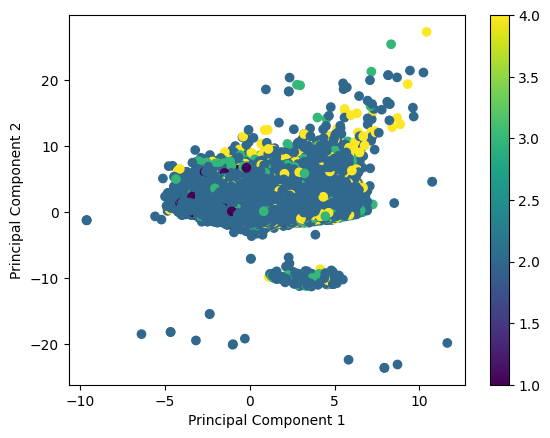

In [14]:
# Plot the first two principal components
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

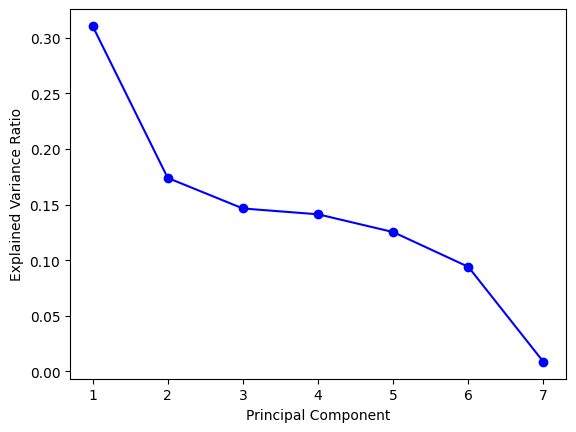

In [15]:
# Plot the explained variance ratio of each principal component
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

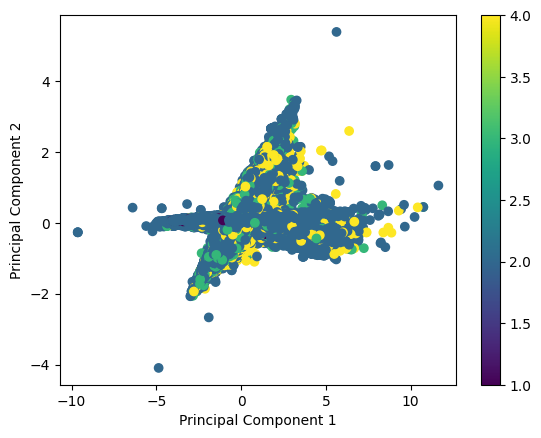

In [16]:
# Plot the first two principal components
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 6], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

# Separate the target variable from the features
y1 = df['severity']
X1 = df.drop(['severity', 'Start_Lat', 'Start_Lng'], axis=1)

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

# Apply PCA to the standardized data
pca = PCA(svd_solver='auto')
X1_train_pca = pca.fit_transform(X1_train_scaled)
X1_test_pca = pca.transform(X1_test_scaled)

# Train a logistic regression classifier on the PCA-transformed data
clf = LogisticRegression()
clf.fit(X1_train_pca, y1_train)

# Evaluate the classifier on the test set
y1_pred = clf.predict(X1_test_pca)
accuracy_Logistic_Regression = accuracy_score(y1_test, y1_pred)
print(f"Accuracy with Logistic Regression: {accuracy_Logistic_Regression}")


Accuracy with Logistic Regression: 0.8899330116147364


Precision_Logistic_Regression: 0.823
Recall_Logistic_Regression: 0.890
Confusion Matrix_Logistic_Regression:
[[     0   5120      0      1]
 [     2 503472     15    222]
 [     0  31048      5     20]
 [     0  25859      2    153]]


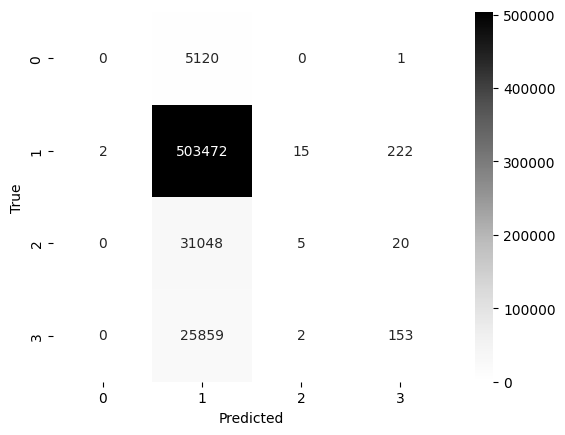

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Evaluate the model
precision_Logistic_Regression = precision_score(y1_test, y1_pred, average='weighted')
recall_Logistic_Regression = recall_score(y1_test, y1_pred, average='weighted')
cm_Logistic_Regression = confusion_matrix(y1_test, y1_pred)

print(f'Precision_Logistic_Regression: {precision_Logistic_Regression:.3f}')
print(f'Recall_Logistic_Regression: {recall_Logistic_Regression:.3f}')
print(f'Confusion Matrix_Logistic_Regression:\n{cm_Logistic_Regression}')

# plot the confusion matrix as a heatmap
sns.heatmap(cm_Logistic_Regression, annot=True, fmt='g', cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_pca, y_train)

y_pred = nb.predict(X_test_pca)
accuracy_Naive_Bayes = accuracy_score(y_test, y_pred)
print(f"Accuracy with NB: {accuracy_Naive_Bayes}")

Accuracy with NB: 0.8501269616323184


Precision_Naive_Bayes: 0.819
Recall_Naive_Bayes: 0.850
Confusion Matrix_Naive_Bayes:
[[   407   4625     50     39]
 [  5069 475296  15827   7519]
 [   603  26428   3513    529]
 [   257  21943   1927   1887]]


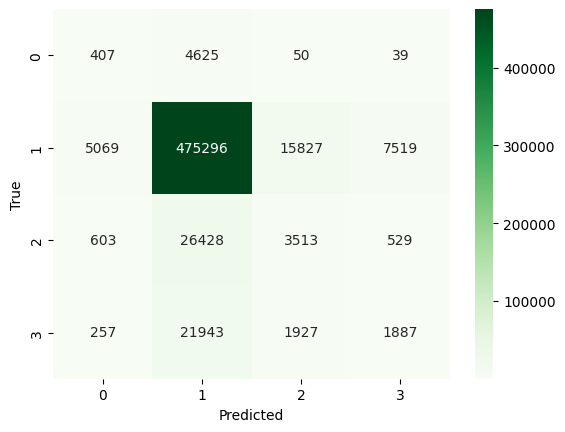

In [24]:
# Evaluate the model

precision_Naive_Bayes = precision_score(y_test, y_pred, average='weighted')
recall_Naive_Bayes = recall_score(y_test, y_pred, average='weighted')
cm_Naive_Bayes = confusion_matrix(y_test, y_pred)

print(f'Precision_Naive_Bayes: {precision_Naive_Bayes:.3f}')
print(f'Recall_Naive_Bayes: {recall_Naive_Bayes:.3f}')
print(f'Confusion Matrix_Naive_Bayes:\n{cm_Naive_Bayes}')

# plot the confusion matrix as a heatmap
sns.heatmap(cm_Naive_Bayes, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Separate the target variable from the features
y2 = df['severity']
X2 = df.drop(['severity', 'Start_Lat', 'Start_Lng'], axis=1)

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.9, random_state=42)

# Standardize the data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Apply PCA to the standardized data
pca = PCA(svd_solver='auto')
X2_train_pca = pca.fit_transform(X2_train_scaled)
X2_test_pca = pca.transform(X2_test_scaled)

# Train the SVM classifier
svm = SVC(kernel='linear', C=0.2)
svm.fit(X2_train_pca, y2_train)

# Make predictions on the test set
y2_pred = svm.predict(X2_test_pca)

# Calculate the accuracy score of the model
accuracy2 = accuracy_score(y2_test, y2_pred)
print(f"Accuracy with SVM: {accuracy2}")


In [ ]:
# Evaluate the model

precision_SVM = precision_score(y2_test, y2_pred, average='weighted')
recall_SVM = recall_score(y2_test, y2_pred, average='weighted')
cm_SVM = confusion_matrix(y2_test, y2_pred)

print(f'Precision_SVM: {precision_SVM:.3f}')
print(f'Recall_SVM: {recall_SVM:.3f}')
print(f'Confusion Matrix_SVM:\n{cm_SVM}')

# plot the confusion matrix as a heatmap
sns.heatmap(cm_SVM, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Step 5: Filter out unnecessary columns
print(df.columns) # This will print the column names in the DataFrame